###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2024 Semester 1

## Assignment 1: Wine quality classification with K-NN


**Student ID(s):**     1356294


##### Readme Instructions on how to run code
Run the code blocks in order to generate the needed graphs and make sure the files winequaility-test.csv and winequality-train.csv are in the same directory as this file

## 1. K-NN classifier

In [5]:
# import required libraries
import pandas as pd
import numpy as np
from typing import Callable

wine_test = pd.read_csv('winequality-test.csv')
wine_train = pd.read_csv('winequality-train.csv')


In [2]:
def majority_vote(neighbors: pd.DataFrame, K: int) -> int:
    """determines the majority vote for a given set of neighbors

    Args:
        neighbors (pd.DataFrame): neighbours of the test data with a 'distance' attribute
        K (int): _description_
    Returns:
        int: _description_
    """

     # Sort by distance and select top K
    nearest_neighbors = neighbors.sort_values("Distance").iloc[:K]

    # Majority vote
    most_common = nearest_neighbors.iloc[:, -2].mode()

    if len(most_common) > 1:
        # Resolve ties by choosing the closest one
        return nearest_neighbors.iloc[0, -2]
    else:
        return most_common.iloc[0]
    

def Knn_Classifier(K: int, train: pd.DataFrame, test: pd.DataFrame, weighting: Callable[[pd.DataFrame,int],int] = majority_vote):
    '''
    This function implements a KNN classifier. It takes in the following arguments:
    K (int) : the number of nearest neighbors to consider
    train (pd.DataFrame): a df containing the train data
    test (pd.DataFrame): a df containing the test data
    '''

    # ensure that the train and test data are of the same shape
    assert train.shape[1] == test.shape[1]

    train_data = train.iloc[:, :-1]
    test_data = test.iloc[:, :-1]


    # ensure that Knn is less than the number of rows in the train data
    assert K <= train.shape[0]

    # list to store the predicted values
    predictions : np.array = np.array([])

    for index, row in test_data.iterrows():
        # Calculate Euclidean distance
        distances = np.sqrt(np.sum((np.array(train_data) - np.array(row)) ** 2, axis=1))
        train['Distance'] = distances

        predictions = np.append(predictions, weighting(train, K))

       

    return predictions

        







## 2. 1-NN classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

In [3]:
predictions = Knn_Classifier(1,pd.read_csv('winequality-train.csv'), pd.read_csv('winequality-test.csv'))

test : pd.DataFrame = pd.read_csv('winequality-test.csv')


# check the accuracy
def compute_accuracy(predictions: pd.Series, actual: pd.Series) -> float:
    """Computes the probabiltiy of a model by looking at the number of correct predictions

    Args:
        predictions (pd.Series): the predictions of the model as a series
        actual (pd.Series): the actual values as a series

    Returns:
        float: _description_
    """

    return predictions[predictions == actual].shape[0] / predictions.shape[0]



print(compute_accuracy(pd.Series(predictions) , test['quality']))

0.7644444444444445


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

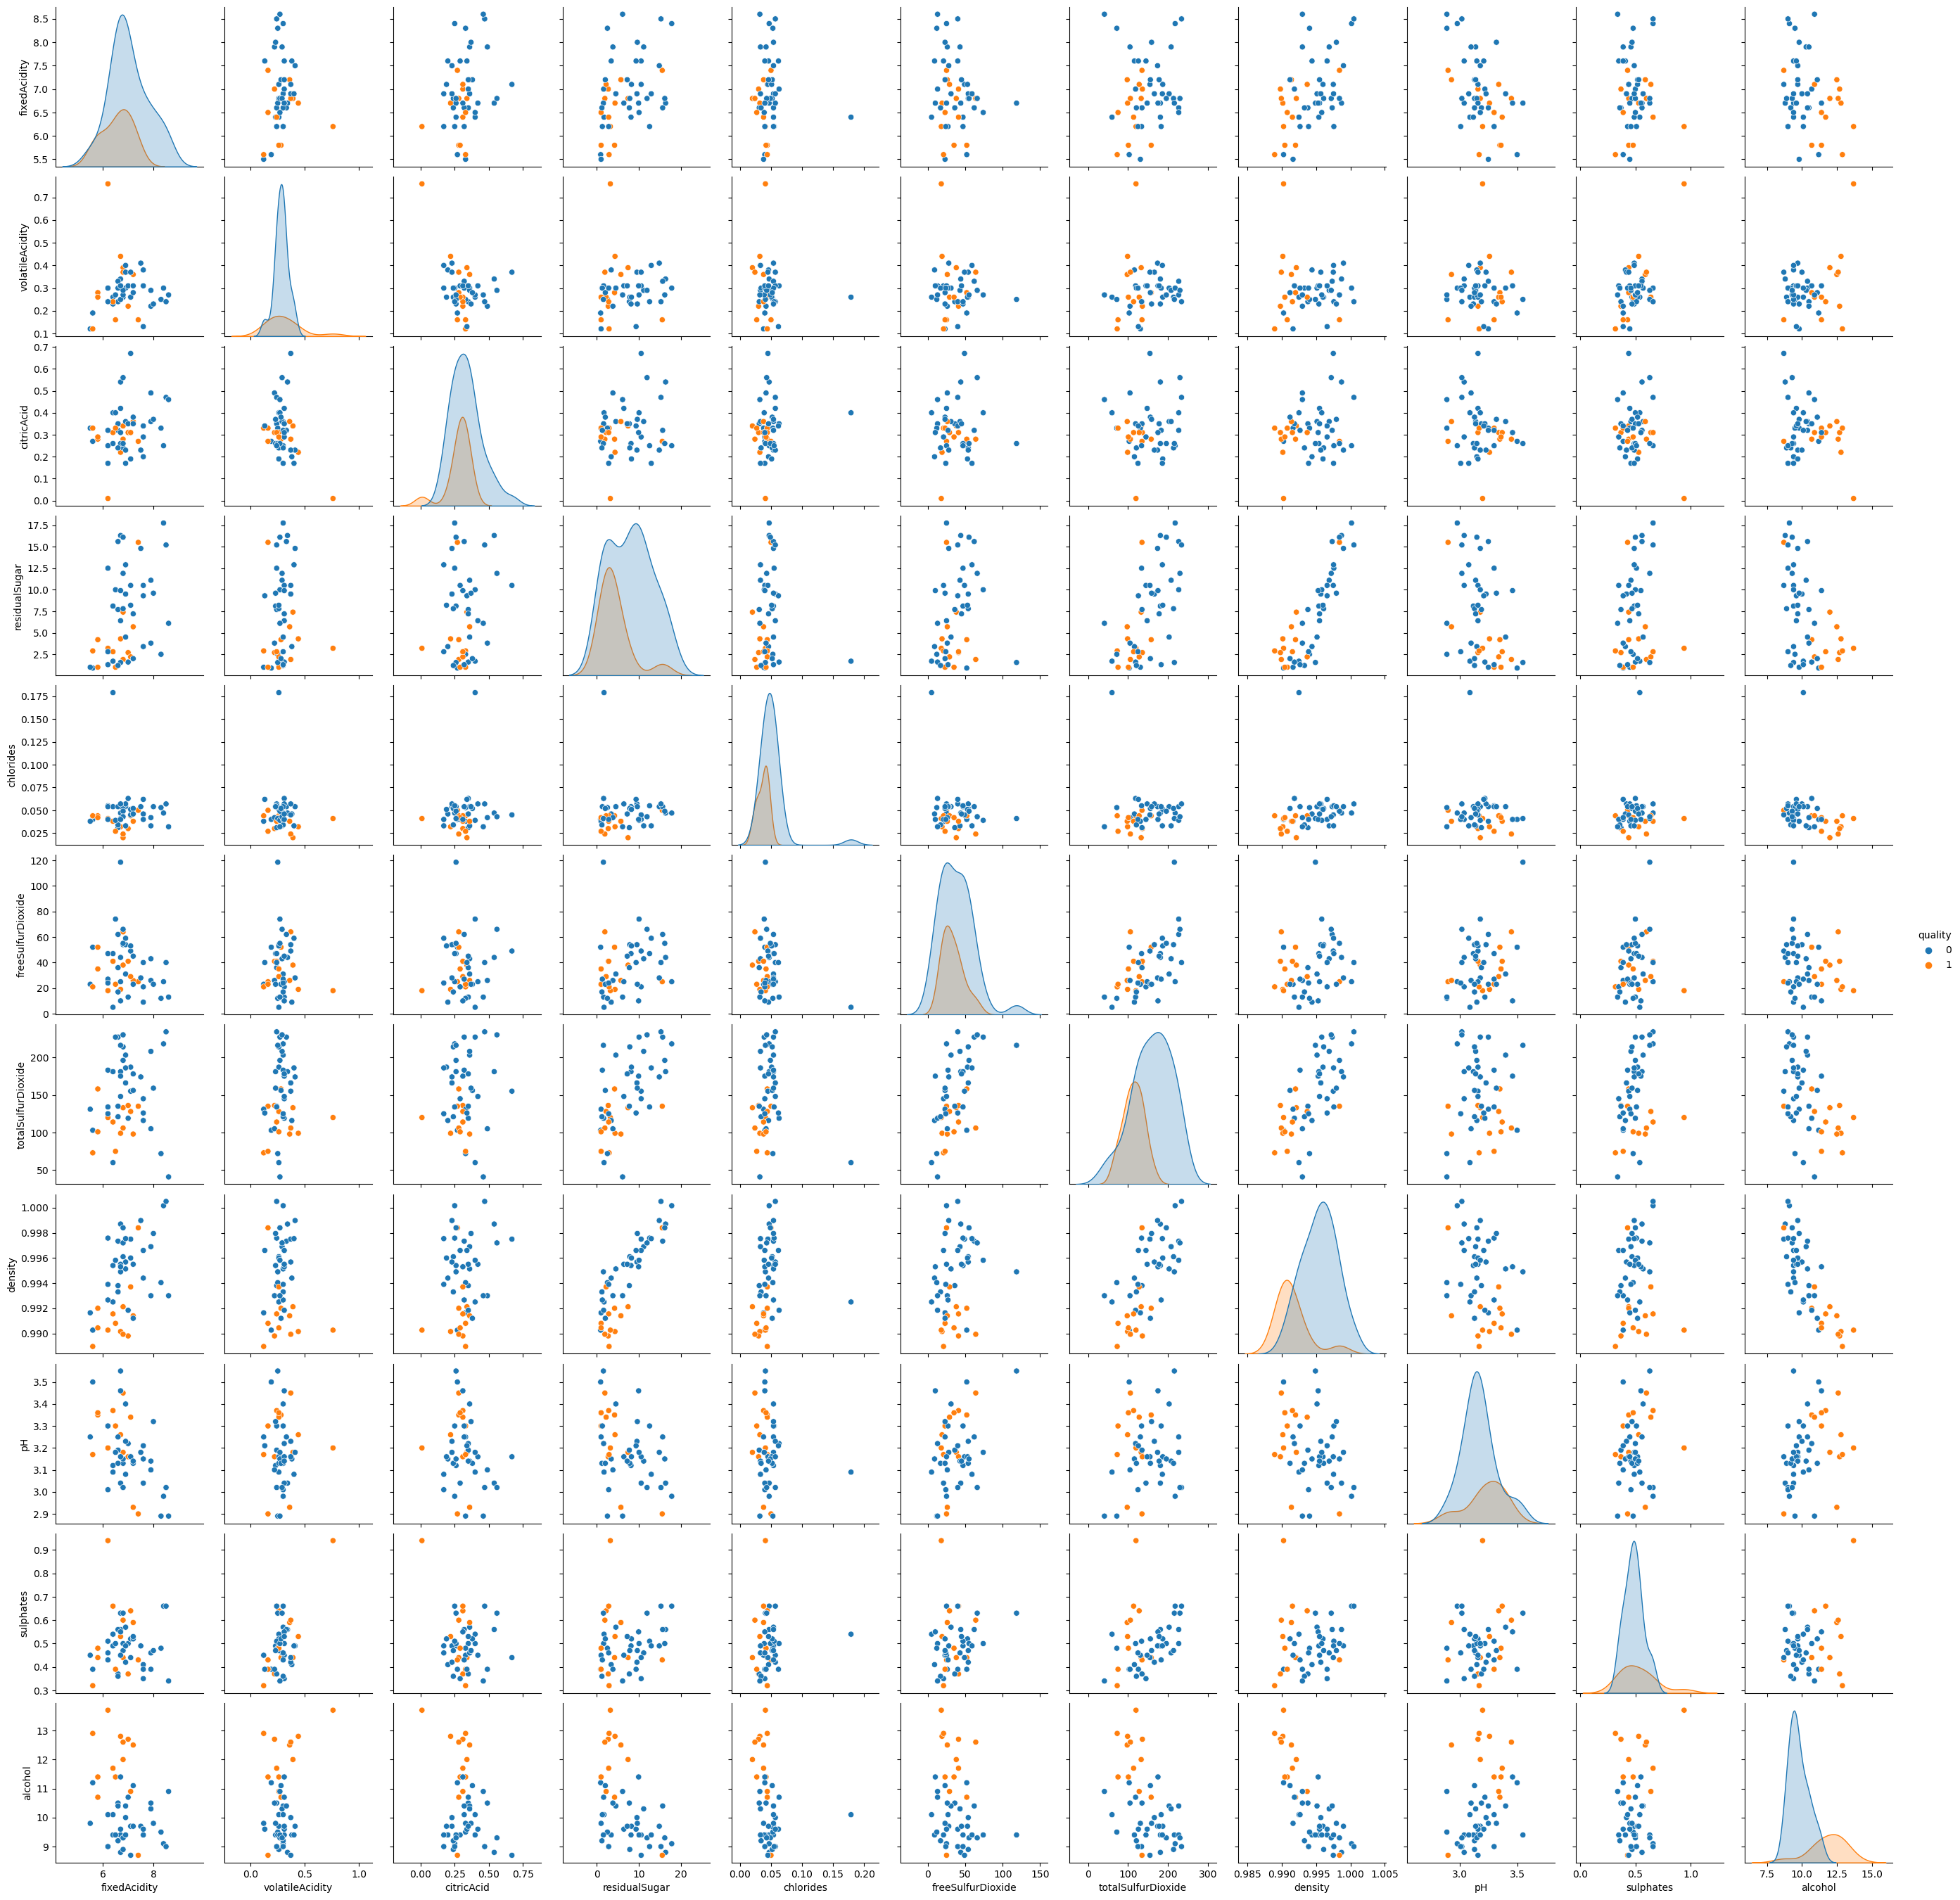

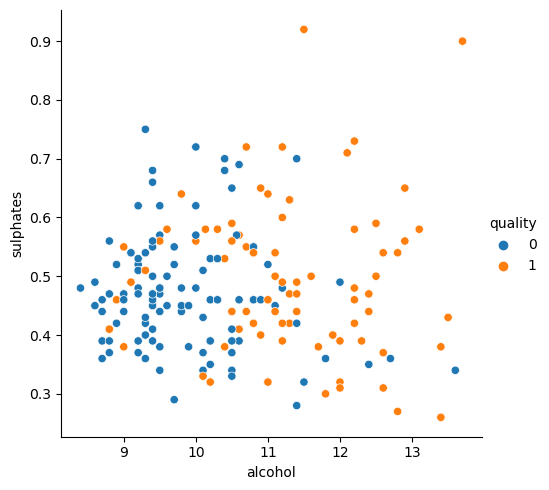

In [4]:
# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# get the data to plot
train = pd.read_csv('winequality-train.csv')
sample = train.sample(200)


# create pairplot to visualize the data
sns.pairplot(train.sample(50), hue='quality')

# chose alcohol and sulphates as the features to plot
sns.relplot(x='alcohol', y='sulphates', hue='quality', data=sample)

## 3. Normalization

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

In [5]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

Xtrain = train.iloc[:,:-1]
ytrain = train.iloc[:,-1]

Xtest = test.iloc[:,:-1]
ytest = test.iloc[:,-1]

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(Xtrain, ytrain)



y_pred = knn.predict(Xtest)
print(y_pred[:10])
accuracy = accuracy_score(ytest, y_pred)
print(accuracy)

[0 0 1 1 1 0 1 0 0 0]
0.8674074074074074


In [6]:
# 1. Min-Max scaling attributes
def min_max_scaling(train: pd.DataFrame, test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    assert train.shape[1] == test.shape[1]
    train_without_quality = train.drop(columns='quality', inplace=False)
    cols = train_without_quality.columns

    new_train: pd.DataFrame = pd.DataFrame()
    new_test: pd.DataFrame = pd.DataFrame()
    for col in cols:
        new_train[col] = (train[col] - train[col].min()) / (train[col].max() - train[col].min())
        new_test[col] = (test[col] - train[col].min()) / (test[col].max() - train[col].min())
    
    new_test['quality'] = test['quality']
    new_train['quality'] = train['quality']
    return new_train, new_test
    

# 2. Standard scaling attributes
def standard_scaling(train: pd.DataFrame, test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    assert train.shape[1] == test.shape[1]
    train_without_quality = train.drop(columns='quality', inplace=False)
    cols = train_without_quality.columns

    new_train: pd.DataFrame = pd.DataFrame()
    new_test: pd.DataFrame = pd.DataFrame()

    
    for col in cols:
        new_train[col] = (train[col] - train[col].mean()) / train[col].std()
        new_test[col] = (test[col] - train[col].mean()) / train[col].std()
    
    new_test['quality'] = test['quality']
    new_train['quality'] = train['quality']
    return new_train, new_test

min_max_labels = Knn_Classifier(1, *min_max_scaling(wine_train, wine_test))
standard_scaling_labels = Knn_Classifier(1, *standard_scaling(wine_train, wine_test))
#normal_labels = Knn_Classifier(1, wine_train, wine_test)


#print(standard_scaling(wine_train, wine_test)[1].head(5))

print(compute_accuracy(pd.Series(min_max_labels), wine_test['quality']))
print(compute_accuracy(pd.Series(standard_scaling_labels), wine_test['quality']))



0.8444444444444444
0.8674074074074074


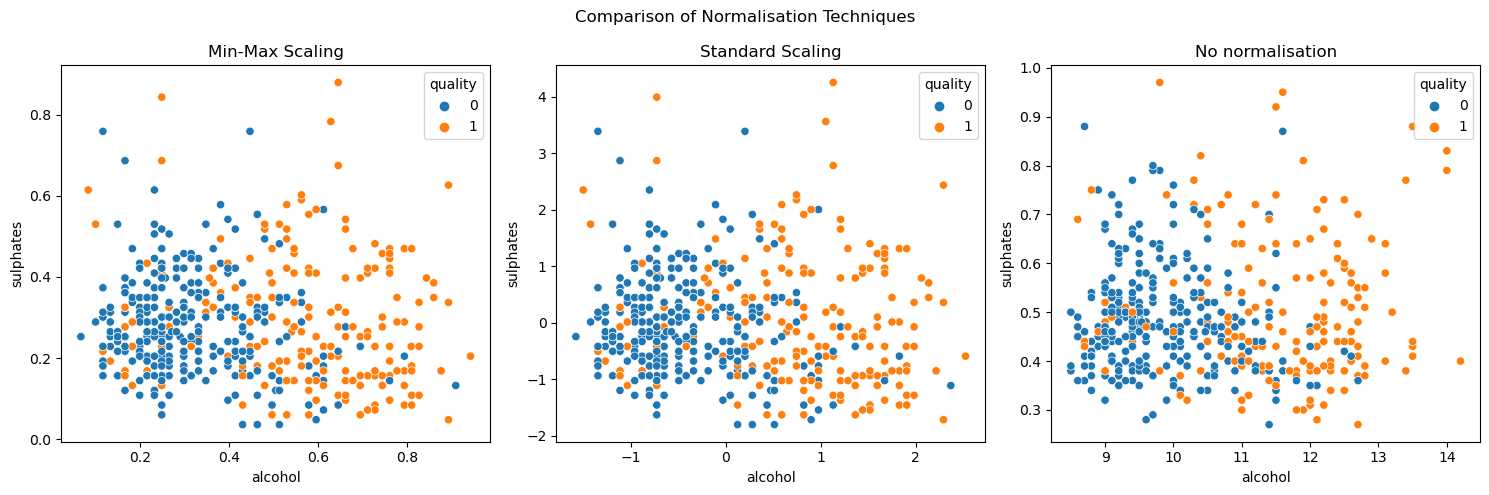

In [18]:

# Create pairplot to visualise data
#sns.pairplot(min_max_scaling(wine_train,wine_test)[1].sample(50), hue='quality')
#sns.pairplot(standard_scaling(wine_train,wine_test)[1].sample(50), hue='quality')

sample_number = 500

# Choose alcohol and sulphates as the features to plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Comparison of Normalisation Techniques')

axes[0].set_title('Min-Max Scaling')
axes[1].set_title('Standard Scaling')
axes[2].set_title('No normalisation')

sns.scatterplot(x='alcohol', y='sulphates', hue='quality', data=min_max_scaling(wine_train,wine_test)[1].sample(500, random_state=1), ax=axes[0])
sns.scatterplot(x='alcohol', y='sulphates', hue='quality', data=standard_scaling(wine_train,wine_test)[1].sample(500, random_state=1),ax=axes[1])
sns.scatterplot(x='alcohol', y='sulphates', hue='quality', data=train.sample(500, random_state=1), ax=axes[2])

plt.tight_layout()
plt.show()

## 4. Model extensions

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### 4.1
Compare the performance of your best 1-NN model from Question 3 to a Gaussian naive Bayes model on this dataset (you may use library functions to implement the Gaussian naive Bayes model). In your write-up, state the accuracy of the naive Bayes model and identify instances where the two models disagree. Why do the two models classify these instances differently?

### 4.2
Implement two additional distance measures for your K-NN model: cosine similarity and Mahalanobis distance (you may use library functions for these distance measures). Do 1-NN classification using each of these new distance measures and the three normalization options from Question 3. Discuss how the new distance metrics compare to Euclidean distance and how each metric is affected by normalization.

### 4.3
Implement either of the two K-NN weighting strategies discussed in lecture (inverse linear distance or inverse distance). Compare the performance of the weighted and majority vote models for a few different values of K. In your write-up, discuss how weighting strategy and the value of K affect the model's decisions.

In [ ]:
def inverse_linear_distance()

### 4.4
Measure the empirical distribution of class labels in the training dataset (what percentage of the training data comes from each class). Then evaluate the distribution of labels predicted by your K-NN model for the test data, for a range of values for K. Does the class distribution of the predicted labels match the class distribution of the training data? Explain why or why not.